/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


S is PSD: False | Symmetric: True
A is PSD: False | Symmetric: True


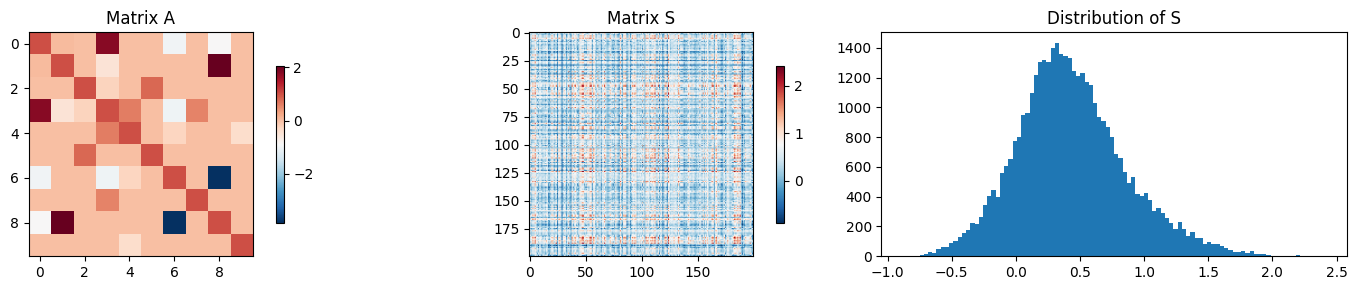

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from srf.models.trifactor_cd import TriFactor
from srf.models.trifactor_svd import make_trifactor_simulation, semi_nmf_cd
from joblib import Parallel, delayed
from tools.rsa import correlate_rsms, compute_rsm
from srf.helpers import load_spose_embedding, best_pairwise_match


RNG = np.random.RandomState(42)

def make_signed_sparse_correlation_psd_matrix(r, rank=None, density=0.2, random_state=42):
    rng = np.random.RandomState(random_state)
    if rank is None:
        rank = r

    # Step 1: Create a sparse low-rank factor matrix B with signed values
    b = 2 * rng.rand(r, rank) - 1  # values in [-1, 1]
    mask = rng.rand(*b.shape) < density
    b *= mask

    # Step 2: Construct PSD matrix A = B B.T
    a = b @ b.T  # symmetric, PSD

    # Step 3: Normalize to make the diagonal 1 => correlation matrix
    d = np.sqrt(np.diag(a))
    d[d == 0] = 1e-8  # avoid division by zero
    a_corr = a / d[:, None] / d[None, :]

    # Step 4: Sparsify, preserving some negative values
    abs_vals = np.abs(a_corr)
    threshold = np.quantile(abs_vals[np.triu_indices(r, k=1)], 1 - density)  # off-diagonal threshold
    keep_mask = (abs_vals >= threshold)
    a_sparse = np.where(keep_mask, a_corr, 0)
    a_sparse = np.triu(a_sparse, 1) + np.triu(a_sparse, 1).T  # symmetrize
    np.fill_diagonal(a_sparse, 1.0)

    return a_sparse


# Simulation setup
def make_trifactor_simulation(n, r, sparsity, random_state=42, snr=0.0):
    RNG = np.random.RandomState(random_state)
    w = 0.5 * RNG.rand(n, r)
    h = w.copy()
    a = np.eye(r)
    mask = RNG.rand(*a.shape) < sparsity
    # we make the interaction matrix a bit stronger
    a[mask] = 5 * (RNG.rand(mask.sum()) - 0.5)
    a = 0.5 * (a + a.T)

    # Bias towards negative signs by using 0.7 threshold instead of 0.5
    signs = 3 * (RNG.rand(*a.shape) > 0.7) - 1
    a = a * signs
    a = 0.5 * (a + a.T)

    s = w @ a @ h.T
    symmetric_noise = RNG.randn(*s.shape)
    symmetric_noise = (symmetric_noise + symmetric_noise.T) / 2
    s = snr * s + (1 - snr) * symmetric_noise
    return s, w, a, h


def is_psd(matrix, tol=1e-8):
    # Check symmetry
    if not np.allclose(matrix, matrix.T, atol=tol):
        return False
    # Check eigenvalues
    eigenvalues = np.linalg.eigvalsh(matrix)
    return np.all(eigenvalues >= -tol)  # allow for numerical noise


def is_symmetric(matrix, tol=1e-8):
    return np.allclose(matrix, matrix.T, atol=tol)


n, r, sparsity = 200, 10, 0.2
s, w, a, h = make_trifactor_simulation(n, r, sparsity, snr=1.0)

print("S is PSD:", is_psd(s), "| Symmetric:", is_symmetric(s))
print("A is PSD:", is_psd(a), "| Symmetric:", is_symmetric(a))
# plot each matrix separately with different sizes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
np.fill_diagonal(a, 1.0)
im1 = ax1.imshow(a, cmap="RdBu_r")
plt.colorbar(im1, ax=ax1, shrink=0.7)
ax1.set_title("Matrix A")

im2 = ax2.imshow(s, cmap="RdBu_r")
plt.colorbar(im2, ax=ax2, shrink=0.7)
ax2.set_title("Matrix S")

ax3.hist(s.flatten(), bins=100)
ax3.set_title("Distribution of S")

plt.tight_layout()
plt.show()

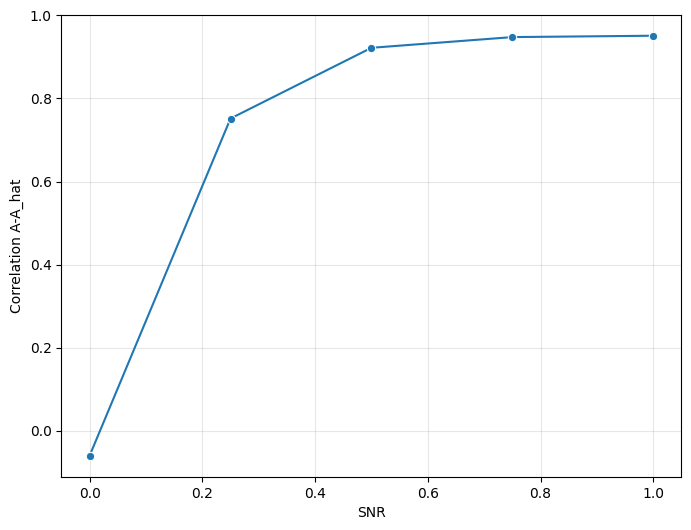

In [57]:
snrs = np.linspace(0.0, 1.0, 5)
noisy_data = [make_trifactor_simulation(n, r, sparsity, snr=snr) for snr in snrs]

# Run across 3 different random initializations
all_corrs = []
for init_seed in range(3):
    model = TriFactor(
        rank=r,
        alpha=1000.0,
        lam=1.0,
        verbose=False,
        cd_inner=100,
        max_iter=300,
        init="random",
        random_state=init_seed,
        w_true=w,
        h_true=h,
        a_true=a,
        a_method="ista",
        update_w=False,
        update_h=False,
        update_a=True,
        freeze_a=0,
    )

    corrs_list = []
    for s, w, a, h in noisy_data:
        model.fit(s)
        a_hat = model.a_
        corrs = correlate_rsms(a, a_hat)
        corrs_list.append(corrs)

    all_corrs.append(corrs_list)
# Calculate mean and std across initializations
mean_corrs = np.mean(all_corrs, axis=0)
std_corrs = np.std(all_corrs, axis=0)

# Create DataFrame for seaborn
df = pd.DataFrame({"SNR": snrs, "Correlation": mean_corrs, "std": std_corrs})

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="SNR", y="Correlation", marker="o", errorbar="sd")
plt.ylabel("Correlation A-A_hat")
plt.xlabel("SNR")
plt.grid(True, alpha=0.3)
plt.show()

In [77]:
model = TriFactor(
    rank=r,
    alpha=100.0,
    lam=1.0,
    verbose=True,
    cd_inner=100,
    max_iter=1000,
    init="random",
    random_state=0,
    w_true=w,
    h_true=h,
    a_true=a,
    rho=1.0,
    a_method="fista",
    update_w=False,
    update_h=False,
    update_a=True,
    freeze_a=0,
)
model.fit(s)
w_hat = model.w_
h_hat = model.h_
a_hat = model.a_
history = model.history

Correlation:  0.9509879705410551
Pearson correlation between w_hat and w: 1.0000 (p=0)


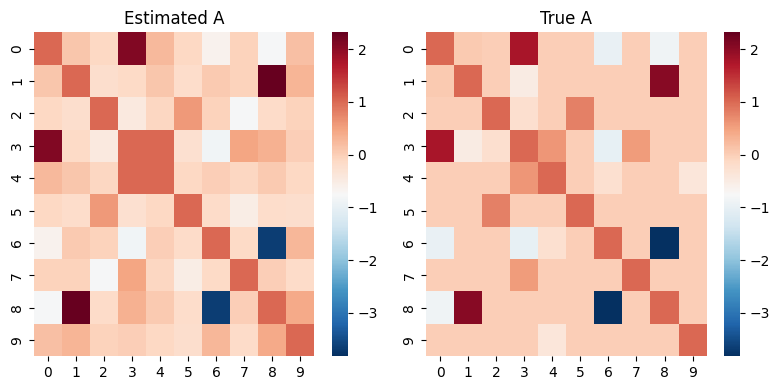

In [79]:
from scipy.stats import pearsonr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
vmin = min(a_hat.min(), a.min())
vmax = max(a_hat.max(), a.max())
sns.heatmap(a_hat, cmap="RdBu_r", ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title("Estimated A")
sns.heatmap(a, cmap="RdBu_r", ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title("True A")
plt.tight_layout()
print("Correlation: ", correlate_rsms(a, a_hat))

# Correlate w_hat with w and print Pearson correlation
pearson_corr, pearson_p = pearsonr(w_hat.flatten(), w.flatten())
print(
    f"Pearson correlation between w_hat and w: {pearson_corr:.4f} (p={pearson_p:.2g})"
)

/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


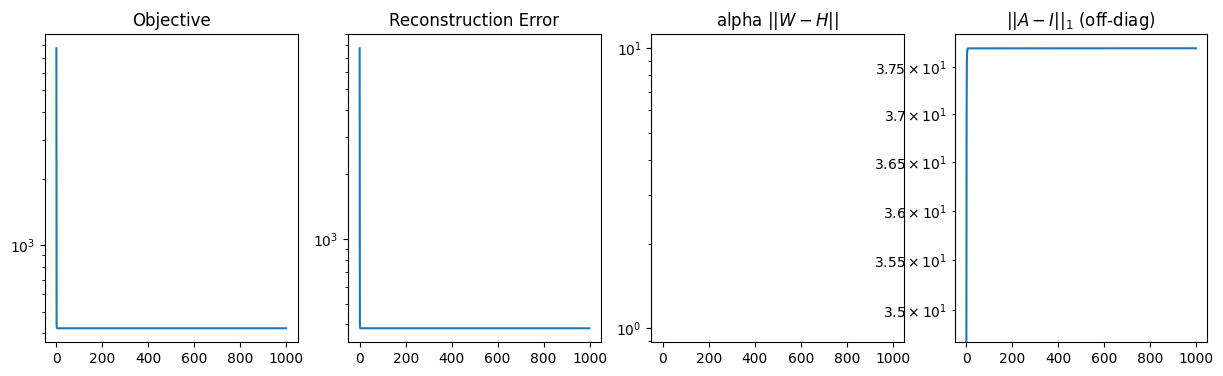

/tmp/ipykernel_2012308/3011499912.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


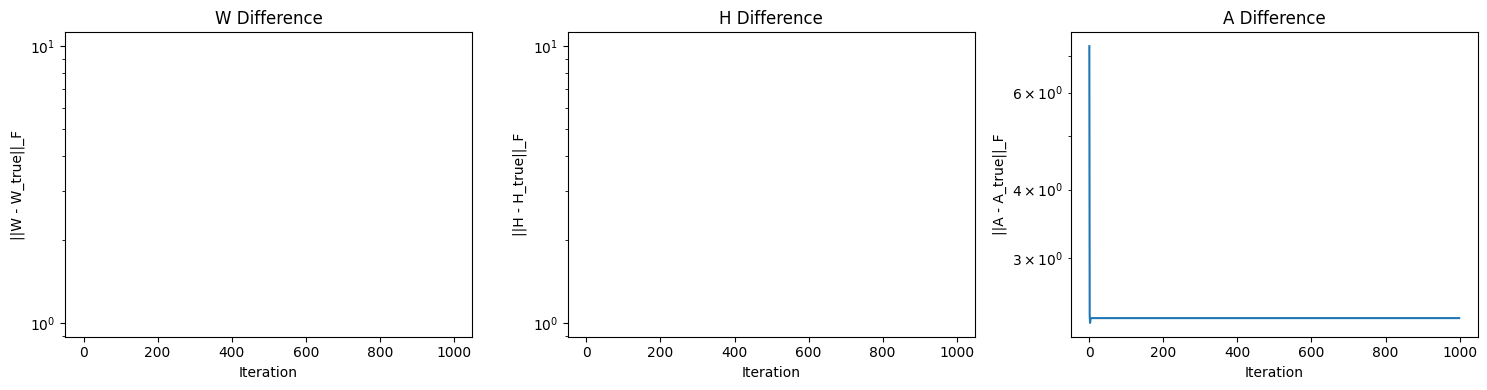

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].semilogy(history["obj"])
axes[0].set_title("Objective")
axes[1].semilogy(history["rec_error"])
axes[1].set_title("Reconstruction Error")
axes[2].semilogy(history["alpha_penalty"])
axes[2].set_title(r"alpha $||W- H||$")
axes[3].semilogy(history["l1_offdiag"])
axes[3].set_title(r"$||A - I||_1$ (off-diag)")
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].semilogy(history["w_diff"])
axes[0].set_title("W Difference")
axes[1].semilogy(history["h_diff"])
axes[1].set_title("H Difference")
axes[2].semilogy(history["a_diff"])
axes[2].set_title("A Difference")

axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("||W - W_true||_F")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("||H - H_true||_F")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("||A - A_true||_F")
plt.tight_layout()
plt.show()

In [49]:
def evaluate_trifactor(s, w, h, a, lam, alpha, max_iter=1000):
    model = TriFactor(
        rank=w.shape[1],
        alpha=alpha,
        lam=lam,
        verbose=False,
        cd_inner=100,
        max_iter=max_iter,
        init="random",
        random_state=0,
        update_a=True,
        a_method="ista",
        freeze_a=0,
    )

    model.fit(s)
    w_hat, h_hat, a_hat = model.w_, model.h_, model.a_

    # Calculate metrics
    s_hat = w_hat @ a_hat @ h_hat.T
    s_error = np.linalg.norm(s - s_hat) / np.linalg.norm(s)
    w_error = np.linalg.norm(w - w_hat) / np.linalg.norm(w)
    h_error = np.linalg.norm(h - h_hat) / np.linalg.norm(h)
    a_error = np.linalg.norm(a - a_hat) / np.linalg.norm(a)

    return {
        "lambda": lam,
        "alpha": alpha,
        "s_error": s_error,
        "w_error": w_error,
        "h_error": h_error,
        "a_error": a_error,
    }


# Create much finer parameter grids
alphas = np.logspace(-1, 3, 30)  # 20 values from 0.1 to 1000
lambdas = np.logspace(0, 0.5, 30)  # 20 values from 0.01 to 5
param_combinations = [(s, w, h, a, lam, alpha) for lam in lambdas for alpha in alphas]

# Run in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_trifactor)(*params) for params in param_combinations
)
results_df = pd.DataFrame(results)

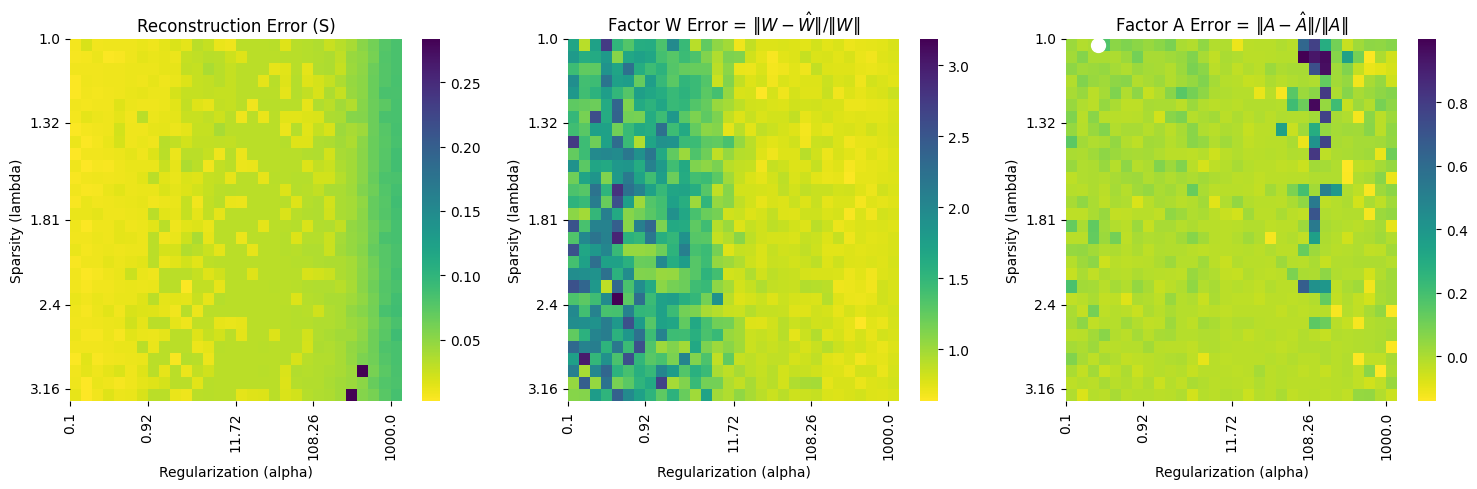

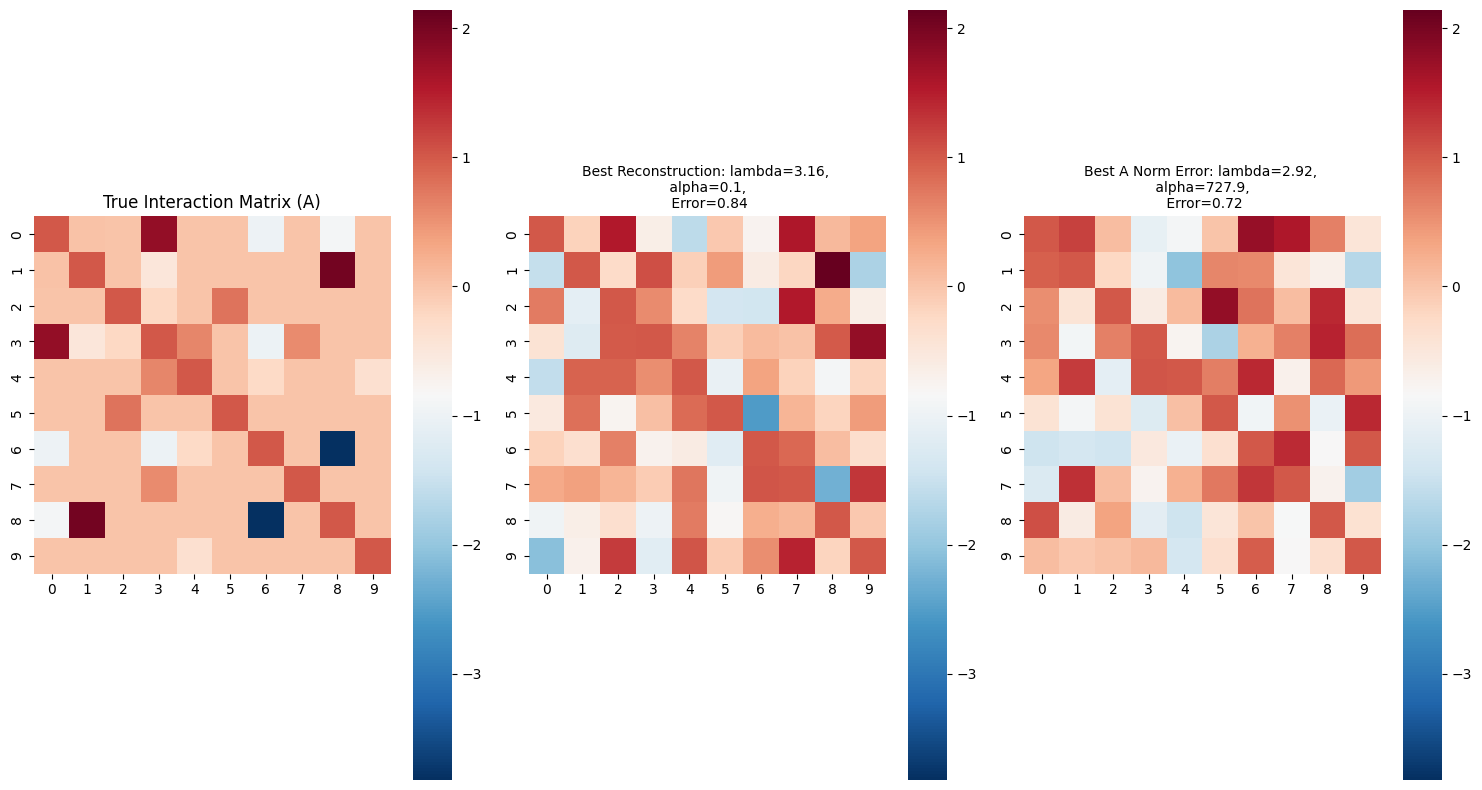

In [50]:
# Create heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ["s_error", "w_error", "a_error"]
titles = [
    "Reconstruction Error (S)",
    r"Factor W Error = $\|W - \hat{W}\|/\|W\|$",
    r"Factor A Error = $\|A - \hat{A}\|/\|A\|$",
]
cmaps = ["viridis_r", "viridis_r", "viridis_r"]

for i, (metric, title, cmap) in enumerate(zip(metrics, titles, cmaps)):
    ax = axes[i]
    pivot = results_df.pivot_table(index="lambda", columns="alpha", values=metric)

    if metric == "a_error":
        # make log scale
        pivot = np.log10(pivot)

    # Create heatmap without annotations due to finer grid
    sns.heatmap(pivot, ax=ax, cmap=cmap, annot=False)

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Regularization (alpha)", fontsize=10)
    ax.set_ylabel("Sparsity (lambda)", fontsize=10)

    # Configure tick density and formatting
    ax.set_xticks(
        [
            0,
            pivot.shape[1] // 4,
            pivot.shape[1] // 2,
            3 * pivot.shape[1] // 4,
            pivot.shape[1] - 1,
        ]
    )
    ax.set_yticks(
        [
            0,
            pivot.shape[0] // 4,
            pivot.shape[0] // 2,
            3 * pivot.shape[0] // 4,
            pivot.shape[0] - 1,
        ]
    )

    # Set tick labels to corresponding alpha/lambda values (rounded)
    x_ticks = [round(alphas[j], 2) for j in ax.get_xticks()]
    y_ticks = [round(lambdas[j], 2) for j in ax.get_yticks()]

    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)

plt.tight_layout()

# Find best hyperparameters - keep best reconstruction, but replace best correlation with best norm
best_recon_idx = results_df["s_error"].idxmin()
best_norm_idx = results_df[
    "a_error"
].idxmin()  # Find lowest A error instead of highest correlation
best_recon_params = results_df.loc[best_recon_idx]
best_norm_params = results_df.loc[best_norm_idx]  # Use these parameters instead

# Train models with best parameters
best_models = []
for params in [best_recon_params, best_norm_params]:
    model = TriFactor(
        rank=r,
        alpha=params["alpha"],
        lam=params["lambda"],
        verbose=False,
        cd_inner=100,
        max_iter=1000,
        init="random",
        random_state=0,
    )
    model.fit(s)
    best_models.append(model)

# Create figure for comparison of models
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# Plot matrices with consistent colorbar ranges
vmin = min(a.min(), min(model.a_.min() for model in best_models))
vmax = max(a.max(), max(model.a_.max() for model in best_models))

# Plot true matrix
sns.heatmap(a, cmap="RdBu_r", ax=axes[0], cbar=True, square=True, vmin=vmin, vmax=vmax)
axes[0].set_title("True Interaction Matrix (A)", fontsize=12)

# Plot estimated matrices
for i, (model, params, title) in enumerate(
    zip(
        best_models,
        [best_recon_params, best_norm_params],
        ["Best Reconstruction", "Best A Norm Error"],
    )
):
    sns.heatmap(
        model.a_,
        cmap="RdBu_r",
        ax=axes[i + 1],
        cbar=True,
        square=True,
        vmin=vmin,
        vmax=vmax,
    )
    axes[i + 1].set_title(
        f"{title}: lambda={params['lambda']:.2f}, \n alpha={params['alpha']:.1f}, \n Error={params['a_error']:.2f}",
        fontsize=10,
    )

# Similarly update your contour plot to use the best_norm_params instead of best_corr_params
ax.scatter(
    np.log10(best_norm_params["alpha"]),
    np.log10(best_norm_params["lambda"]),
    color="white",
    marker="o",
    s=100,
    label="Best A Norm Error",
)
plt.tight_layout()
plt.show()

In [51]:
def print_fit_summary(s, w, h, a, model):
    # Get factors from model
    w_hat = model.w_
    h_hat = model.h_
    a_hat = model.a_
    r = model.rank

    # Calculate reconstruction error
    s_hat = w_hat @ a_hat @ h_hat.T
    s_error = np.linalg.norm(s - s_hat)

    # Calculate factor errors
    w_error = np.linalg.norm(w - w_hat)
    h_error = np.linalg.norm(h - h_hat)
    a_error = np.linalg.norm(a - a_hat)

    # Calculate W-H difference
    w_h_diff = np.linalg.norm(w - h)

    # Calculate correlation between true and estimated A (upper triangular)
    corr = np.corrcoef(a[np.triu_indices(r, k=1)], a_hat[np.triu_indices(r, k=1)])[0, 1]

    # Print summary
    print("\n=== Fit Summary ===")
    print(f"Reconstruction error: {s_error:.4f}")
    print(f"W error: {w_error:.4f}")
    print(f"H error: {h_error:.4f}")
    print(f"A error: {a_error:.4f}")
    print(f"W - H error: {w_h_diff:.4f}")
    print(f"Correlation A A_hat: {corr:.4f}")
    print("==================")


=== Fit Summary ===
Reconstruction error: 3.9749
W error: 9.5389
H error: 9.5386
A error: 11.5551
W - H error: 0.0000
Correlation A A_hat: -0.0316


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def make_trifactor_simulation(n, r, sparsity, random_state=42, snr=0.0):
    RNG = np.random.RandomState(random_state)
    w = 0.5 * RNG.rand(n, r)
    h = w.copy()
    # a = np.eye(r)
    a = np.random.randn(r, r)
    # mask = RNG.rand(*a.shape) < sparsity
    # # we make the interaction matrix a bit stronger
    # a[mask] = 5 * (RNG.rand(mask.sum()) - 0.5)
    # a = 0.5 * (a + a.T)

    # # Bias towards negative signs by using 0.7 threshold instead of 0.5
    # signs = 3 * (RNG.rand(*a.shape) > 0.7) - 1
    # a = a * signs
    a = 0.5 * (a + a.T)
    np.fill_diagonal(a, 1)

    s = w @ a @ h.T
    symmetric_noise = RNG.randn(*s.shape)
    symmetric_noise = (symmetric_noise + symmetric_noise.T) / 2
    s = snr * s + (1 - snr) * symmetric_noise
    return s, w, a, h


def separate_positive(m):
    return (np.abs(m) + m) / 2.0


def separate_negative(m):
    return (np.abs(m) - m) / 2.0


def update_q(u, w):
    return u @ np.linalg.pinv(w)


def update_w(u, w, q, epsilon=1e-9):
    qu = q.T @ u
    qq = q.T @ q
    num = separate_positive(qu) + (separate_negative(qq) @ w)
    den = separate_negative(qu) + (separate_positive(qq) @ w) + epsilon

    return w * np.sqrt(num / den)


def snmf(u, k, niter=100, seed=None, eps0=1e-4, eps=1e-9, callback=None):

    rng = np.random.RandomState(seed)
    k, n = u.shape
    w = rng.rand(k, n) + eps0
    q = rng.rand(k, k) + eps0

    errors = np.zeros(niter)

    for i in range(niter):
        q = update_q(u, w)
        w = update_w(u, w, q)

        err = np.linalg.norm(u - q @ w, "fro") ** 2  # Squared Frobenius norm
        errors[i] = err
        print("Squared Frobenius norm error:", err, end="\r")
        if callback is not None:
            callback(i, w, h, err)

    return w, q, errors


def issymmetric(s):
    if s.shape[0] != s.shape[1]:
        return False
    return np.allclose(s, s.T)


def symmetric_svd(s):
    assert issymmetric(s), "s must be symmetric"
    u, sigma, u_t = np.linalg.svd(s)
    return u, sigma


def truncated_symmetric_svd(s, rank):
    u, sigma = symmetric_svd(s)
    u_truncated = u[:, :rank]
    sigma_truncated = np.diag(sigma[:rank])
    explained_variance_ratio = sigma[:rank] / np.sum(sigma)
    return u_truncated, sigma_truncated, explained_variance_ratio


max_iter = 10_000
n, k = 200, 10
s, w, a, h = make_trifactor_simulation(n, k, sparsity=0.2, snr=1.0, random_state=0)

u, sigma, evar = truncated_symmetric_svd(s, k)
w, q, errors = snmf(u.T, k, max_iter)


a_hat = q.T @ sigma @ q
s_hat = w.T @ a @ w

# Calculate Frobenius norm error
frob = np.linalg.norm(s - s_hat, "fro") ** 2

print("\nFrobenius norm error S_hat:", frob)
print("Frobenius norm error U:", np.linalg.norm(u.T - q @ w, "fro") ** 2)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].semilogy(np.diag(sigma))
ax[0].set_title("Singular values")
ax[1].semilogy(errors)
ax[1].set_title("Errors")
plt.tight_layout()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Find the global min and max values across both matrices
vmin = min(a.min(), a_hat.min())
vmax = max(a.max(), a_hat.max())

sns.heatmap(a, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax1.set_title("True A matrix")

sns.heatmap(a_hat, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax2.set_title("Reconstructed A matrix")
# Calculate correlation using only upper triangular elements
mask = np.triu_indices_from(a, k=1)  # k=1 to exclude diagonal
a_triu = a[mask]
a_hat_triu = a_hat[mask]
corr = np.corrcoef(a_triu, a_hat_triu)[0, 1]
fig.suptitle(f"corr={corr:.3f}")

plt.tight_layout()
plt.show()

iter  550  obj = 0.0126
---------------- summary ----------------
iterations               : 600
final objective          : 1.2703e-02
monotone decreasing path : False
W non-negative           : True
R² on U                  : 0.9982
variance explained in S  : 0.9946
correlation between a and a_hat: -0.0429
frobenius error a true - ahat: 12.8847


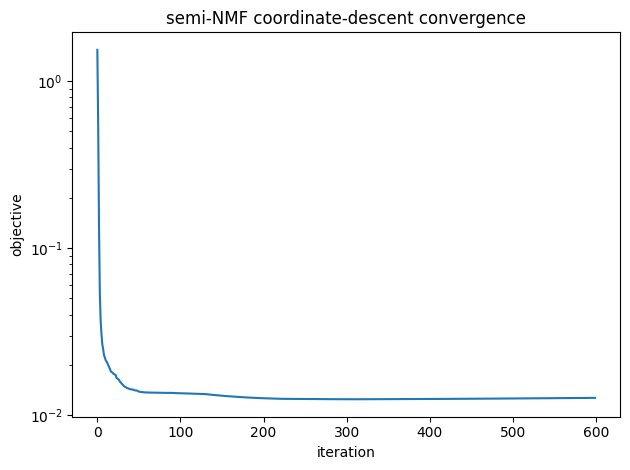

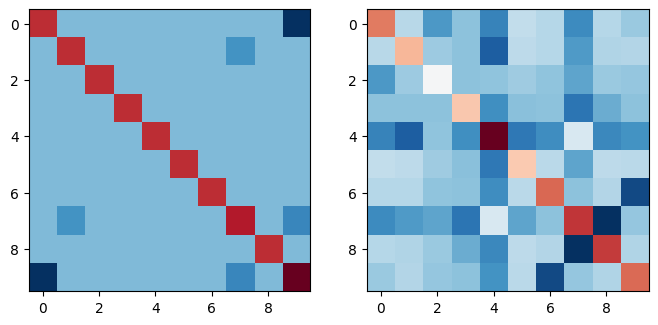

In [27]:
from srf.models.trifactor_svd import (
    make_trifactor_simulation,
    semi_nmf_cd,
    truncated_symmetric_svd,
)
from scipy.linalg import norm

n, k = 100, 10
s, w, a = make_trifactor_simulation(n, k, sparsity=0.2, snr=1.0, random_state=0)


u, sigma, _ = truncated_symmetric_svd(s, k)  # u is orthonormal


w_hat, q_hat, obj_path = semi_nmf_cd(
    u, alpha=1e-4, max_iter=600, tol=1e-5, random_state=0, verbose=True
)
# --- reconstruct S_hat correctly --------------------------------
a_hat = q_hat.T @ np.diag(sigma) @ q_hat
s_hat = w_hat @ a_hat @ w_hat.T

# --- diagnostics ------------------------------------------------
r2_x = 1 - norm(u - w_hat @ q_hat.T, "fro") ** 2 / norm(u, "fro") ** 2
var_explained = 1 - norm(s - s_hat, "fro") ** 2 / norm(s, "fro") ** 2
is_monotone = all(obj_path[i] >= obj_path[i + 1] for i in range(len(obj_path) - 1))
w_nonneg = np.all(w_hat >= -1e-10)

print("\n---------------- summary ----------------")
print(f"iterations               : {len(obj_path)}")
print(f"final objective          : {obj_path[-1]:.4e}")
print(f"monotone decreasing path : {is_monotone}")
print(f"W non-negative           : {w_nonneg}")
print(f"R² on U                  : {r2_x:.4f}")
print(f"variance explained in S  : {var_explained:.4f}")

# --- convergence plot ------------------------------------------
plt.figure()
plt.semilogy(obj_path)
plt.xlabel("iteration")
plt.ylabel("objective")
plt.title("semi-NMF coordinate-descent convergence")
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(a, cmap="RdBu_r")
ax[1].imshow(a_hat, cmap="RdBu_r")
# correlate both a and a hat
print(f"correlation between a and a_hat: {np.corrcoef(a, a_hat)[0, 1]:.4f}")
print(
    f"frobenius error a true - ahat: {np.linalg.norm(a - a_hat, 'fro') / np.linalg.norm(a, 'fro'):.4f}"
)

correlation between a and a_hat: -0.0429
frobenius error a true - ahat: 0.9787


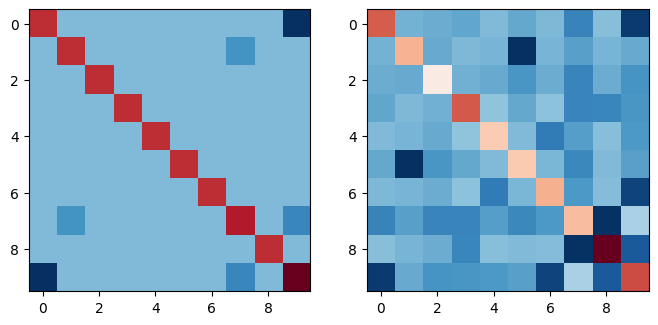

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(a, cmap="RdBu_r")
ax[1].imshow(a_hat, cmap="RdBu_r")
# correlate both a and a hat
print(f"correlation between a and a_hat: {np.corrcoef(a, a_hat)[0, 1]:.4f}")
print(
    f"frobenius error a true - ahat: {np.linalg.norm(a - a_hat, 'fro') / np.linalg.norm(a, 'fro'):.4f}"
)